<a href="https://colab.research.google.com/github/MiguelViapiana/aula-dataScience/blob/main/CNHDetrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

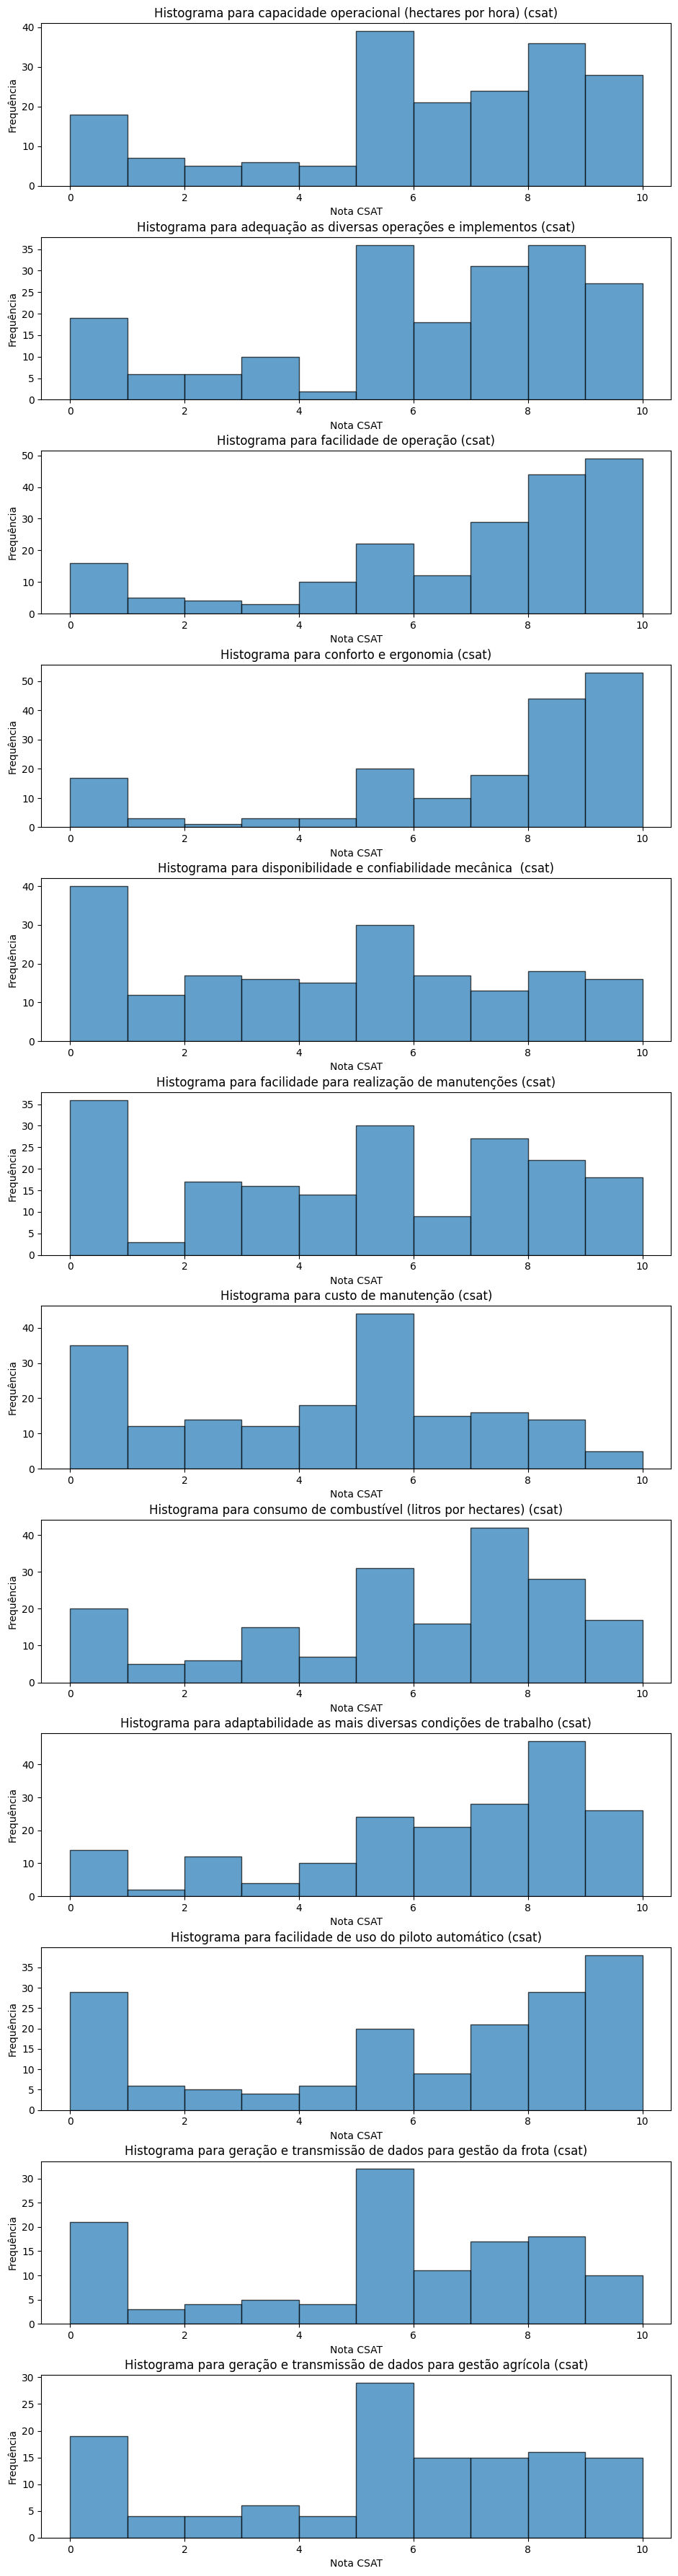

In [9]:
import matplotlib.pyplot as plt

# Filtrar as respostas de NPS com notas de 0 a 6 (detratores)
df_detratores = df[df['nota'].between(0, 6)]

# Selecionar apenas as colunas de CSAT (excluindo a coluna 'nota')
csat_columns = df_detratores.columns.drop('nota')

# Criar histogramas para cada pergunta de CSAT
fig, axes = plt.subplots(len(csat_columns), 1, figsize=(10, len(csat_columns) * 3))
fig.tight_layout(pad=3.0)

for i, column in enumerate(csat_columns):
    # Plotar o histograma da coluna
    axes[i].hist(df_detratores[column].dropna(), bins=10, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Histograma para {column}')
    axes[i].set_xlabel('Nota CSAT')
    axes[i].set_ylabel('Frequência')

# Exibir os histogramas
plt.show()

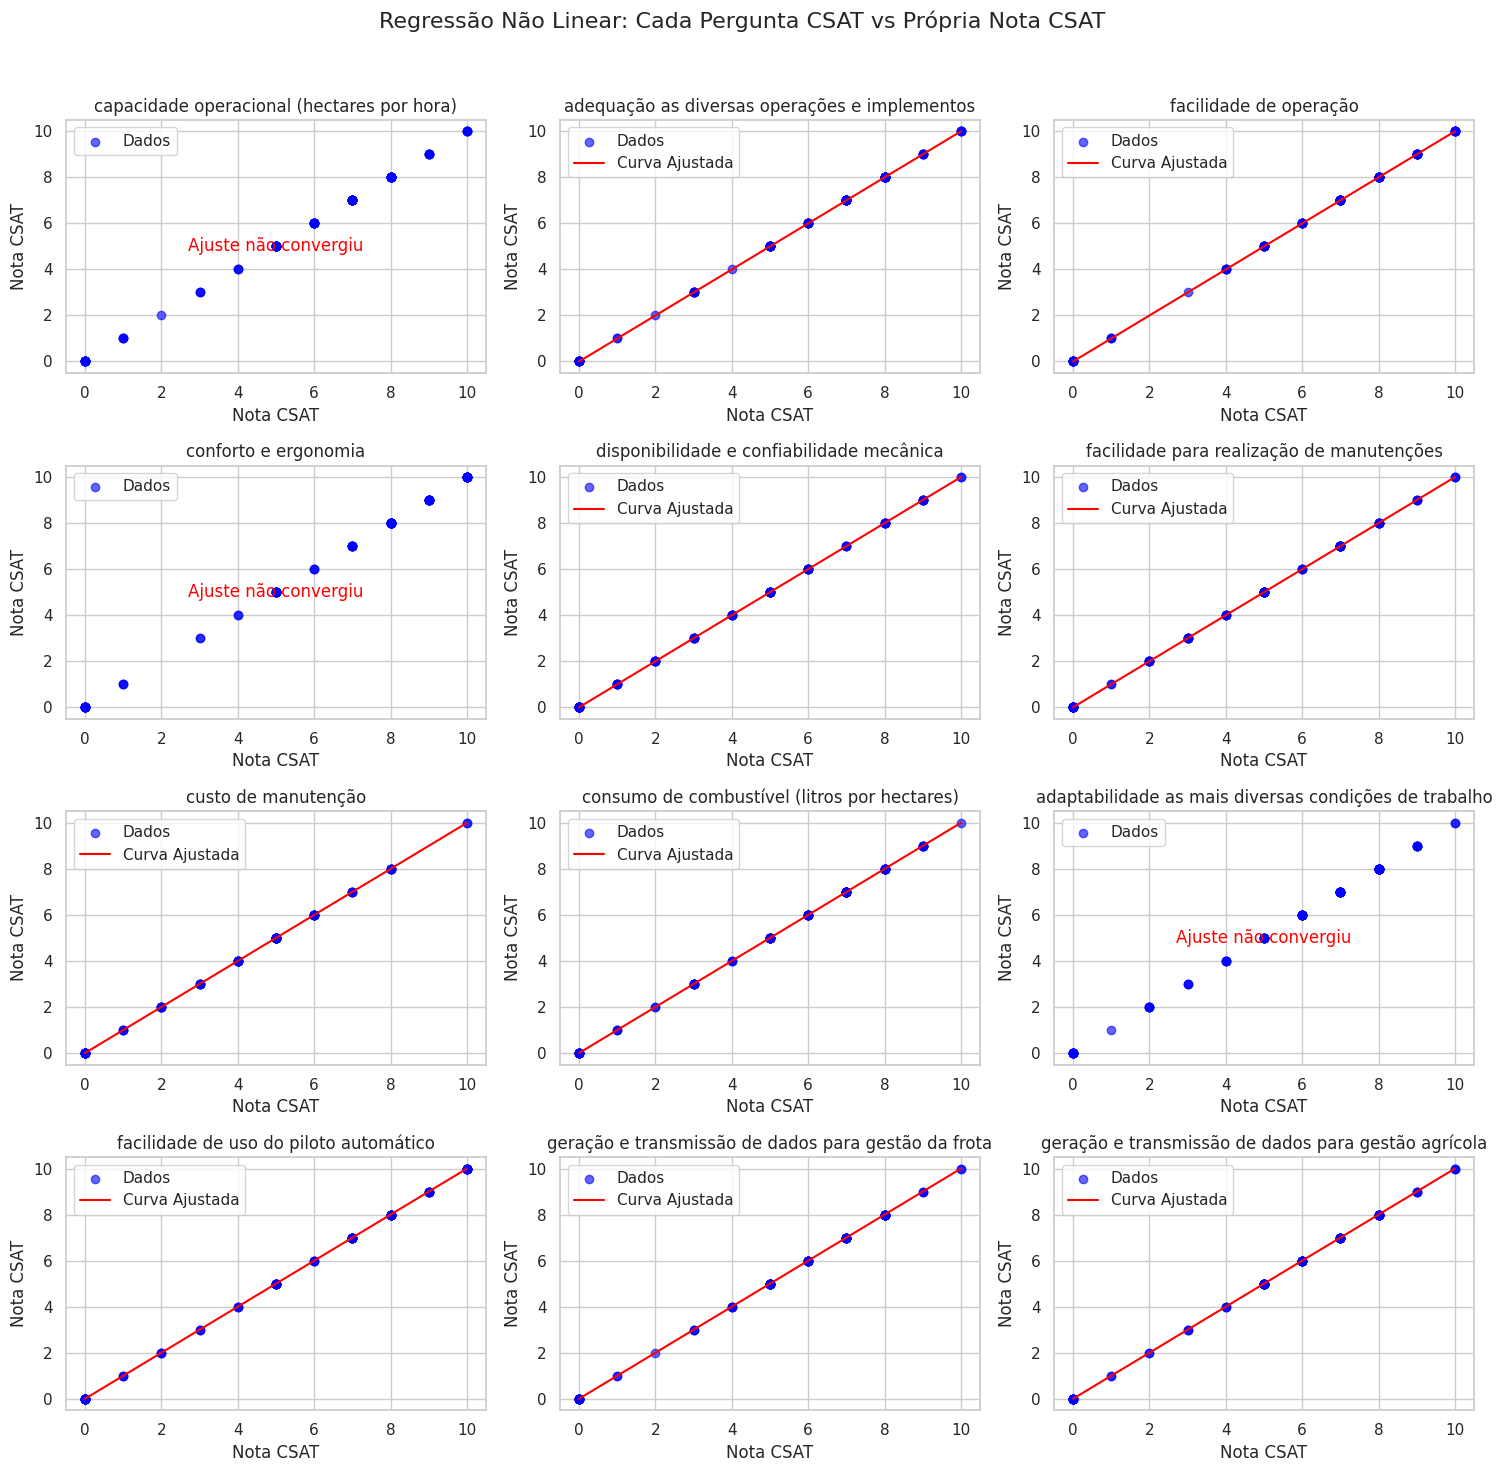

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Carregar o arquivo Excel
file_path = '/content/PlanilhaFiltradaDetratorCNH.xlsx'
data = pd.read_excel(file_path)

# Filtrar as colunas relevantes (CSAT e nota NPS) e remover linhas com valores ausentes
csat_columns = [col for col in data.columns if '(csat)' in col]
df = data[['nota'] + csat_columns].dropna()

# Função para uma curva não linear genérica (exponencial) para ajustar cada CSAT com a sua própria nota
def non_linear_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Configuração de estilo para os gráficos
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
fig.suptitle('Regressão Não Linear: Cada Pergunta CSAT vs Própria Nota CSAT', fontsize=16)
axes = axes.flatten()

# Criar gráfico de regressão não linear para cada pergunta CSAT em relação à sua própria nota
for i, col in enumerate(csat_columns):
    # Gráfico de dispersão
    x_data = df[col].values
    y_data = df[col].values  # Alterado para usar a nota da própria pergunta CSAT
    axes[i].scatter(x_data, y_data, color='blue', label='Dados', alpha=0.6)

    # Ajuste da curva de regressão não linear
    try:
        params, _ = curve_fit(non_linear_func, x_data, y_data, maxfev=10000)
        x_fit = np.linspace(min(x_data), max(x_data), 100)
        y_fit = non_linear_func(x_fit, *params)
        axes[i].plot(x_fit, y_fit, color='red', label='Curva Ajustada')
    except RuntimeError:
        axes[i].text(0.5, 0.5, 'Ajuste não convergiu', transform=axes[i].transAxes,
                     ha='center', va='center', color='red')

    # Configurações do gráfico
    axes[i].set_title(col.replace('(csat)', '').strip())
    axes[i].set_xlabel('Nota CSAT')
    axes[i].set_ylabel('Nota CSAT')  # Alterado para nota da própria pergunta
    axes[i].legend()

# Ajuste de layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


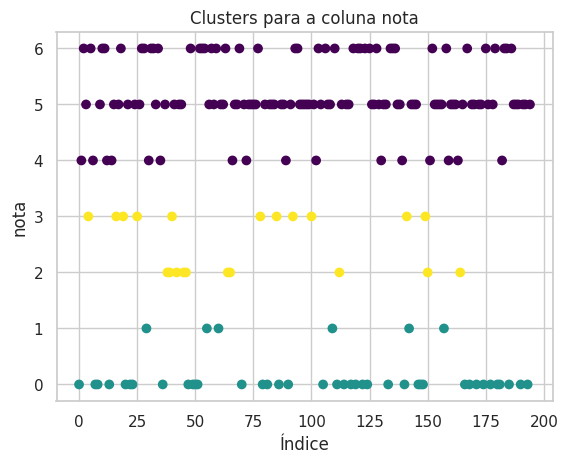

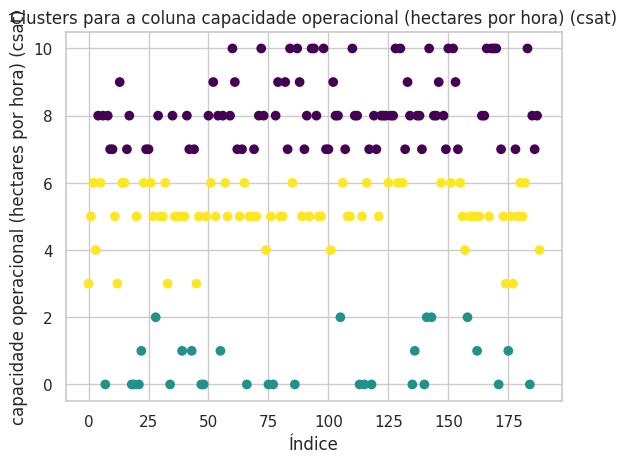

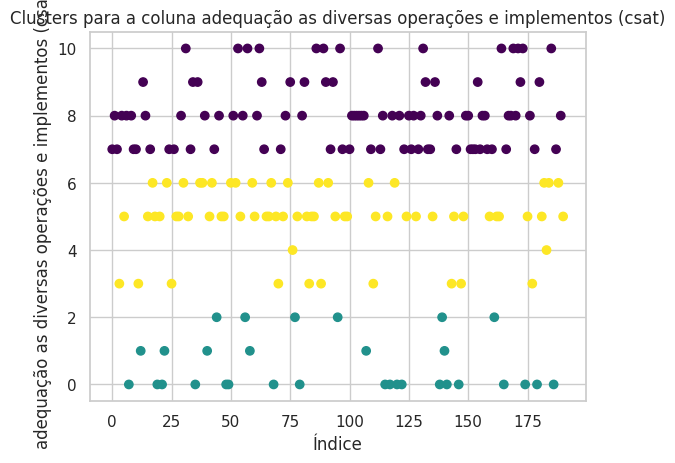

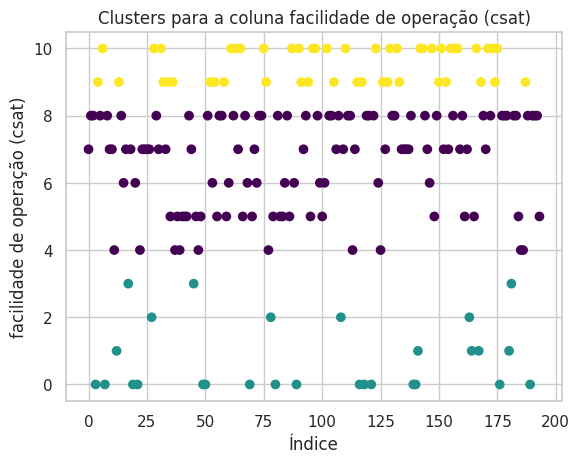

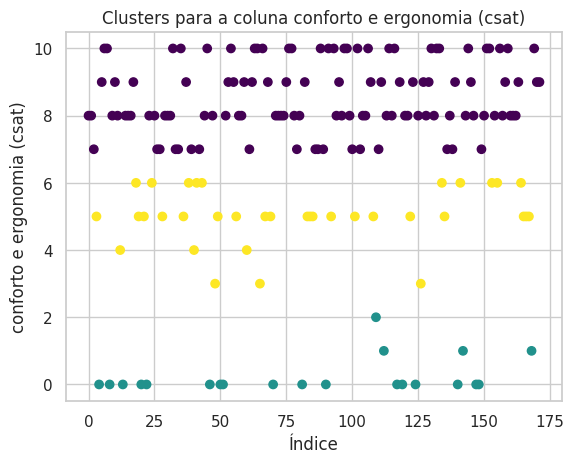

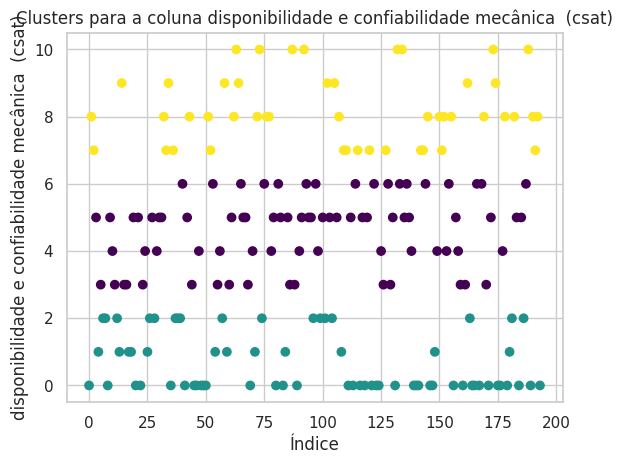

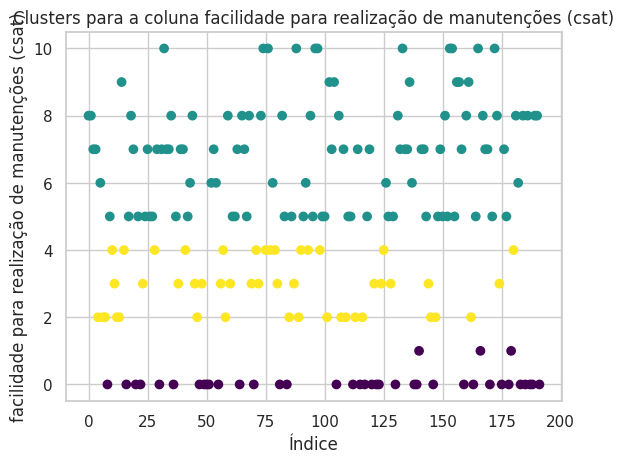

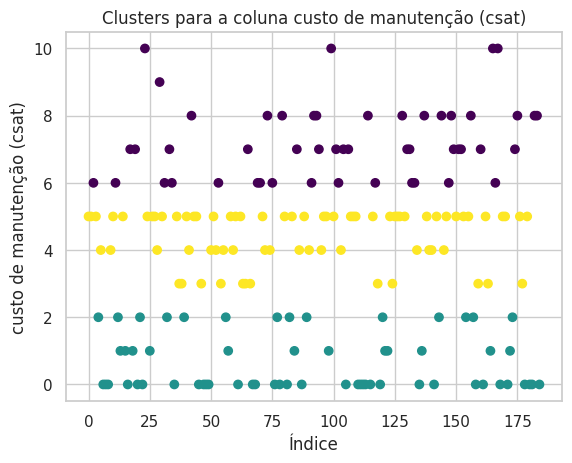

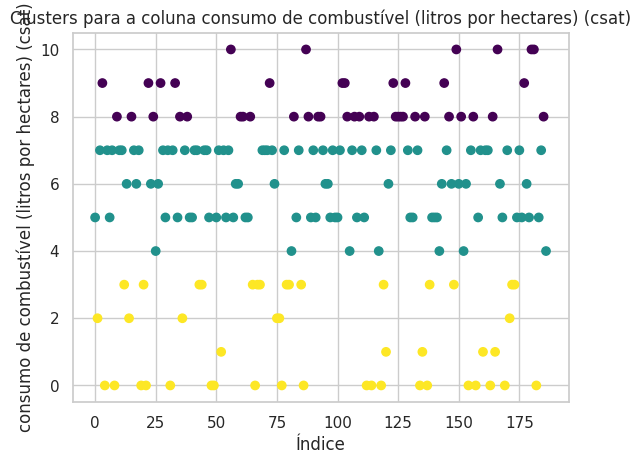

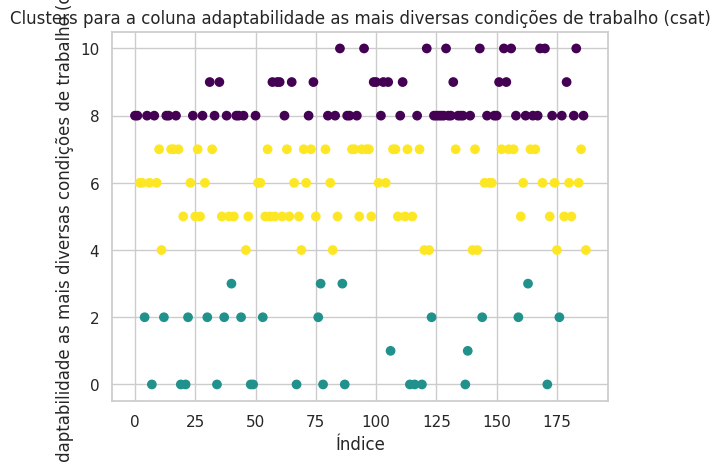

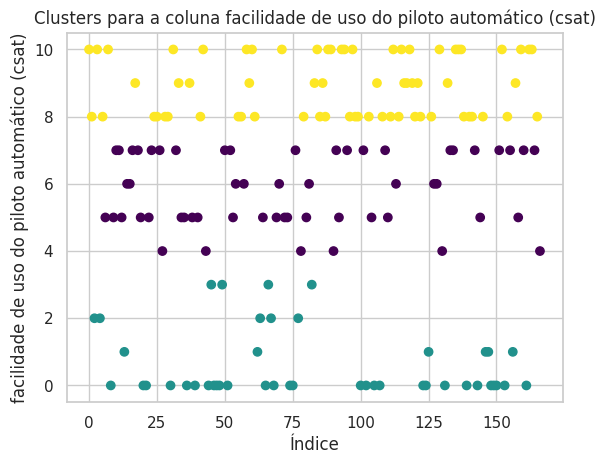

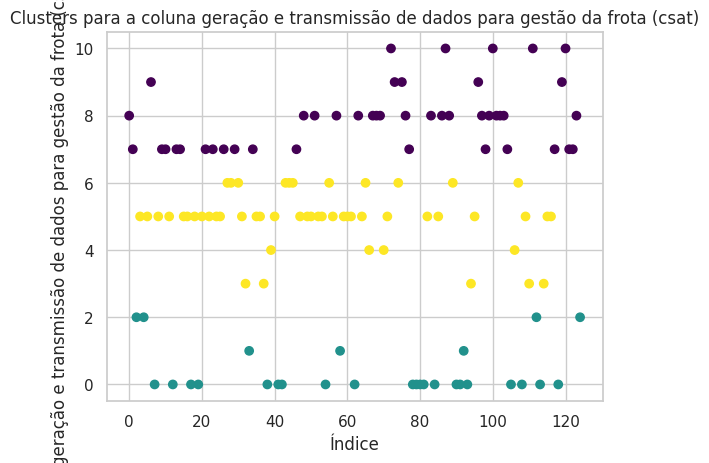

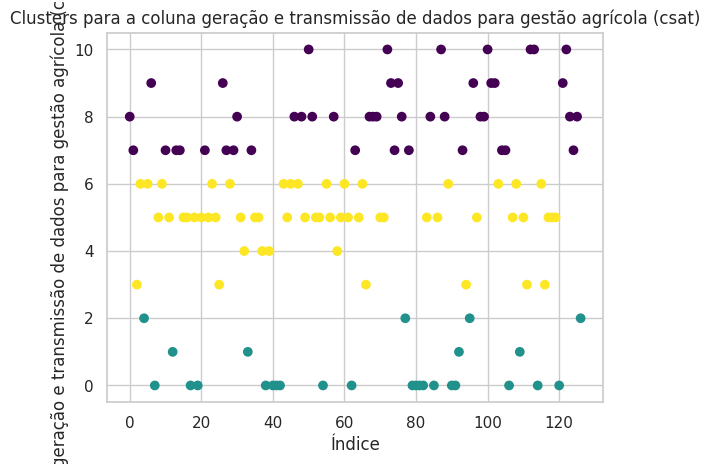

In [12]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carregar a planilha
file_path = '/content/PlanilhaFiltradaDetratorCNH.xlsx'  # Substitua pelo caminho do arquivo
data = pd.read_excel(file_path)

# Identificar colunas numéricas
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Dicionário para armazenar os resultados
kmeans_results = {}

# Aplicar k-means em cada coluna numérica
for col in numeric_cols:
    # Remover valores nulos para o k-means
    column_data = data[col].dropna().values.reshape(-1, 1)

    # Escolher o número de clusters (exemplo com 3 clusters)
    kmeans = KMeans(n_clusters=3, random_state=0)
    clusters = kmeans.fit_predict(column_data)

    # Adicionar os resultados ao dicionário
    kmeans_results[col] = clusters

    # Plotar os clusters para visualização
    plt.figure()
    plt.scatter(range(len(clusters)), column_data, c=clusters, cmap='viridis')
    plt.title(f'Clusters para a coluna {col}')
    plt.xlabel('Índice')
    plt.ylabel(col)
    plt.show()



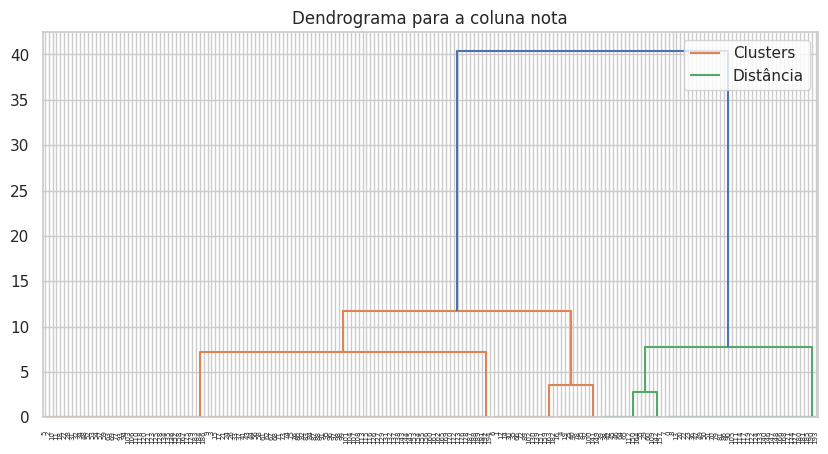

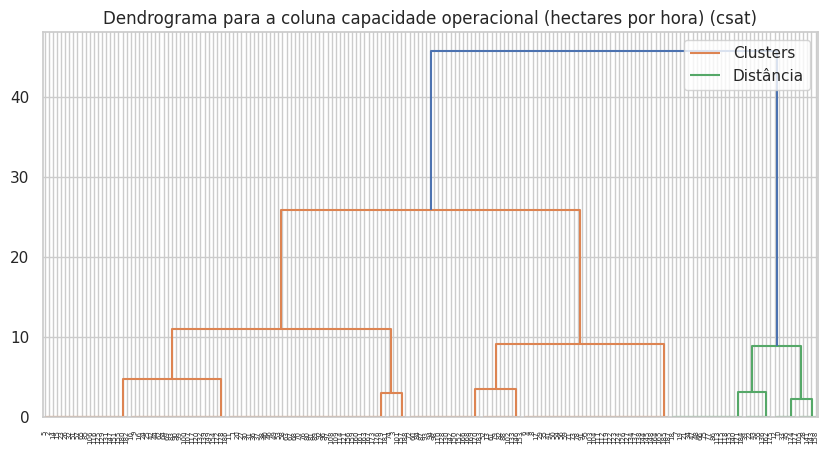

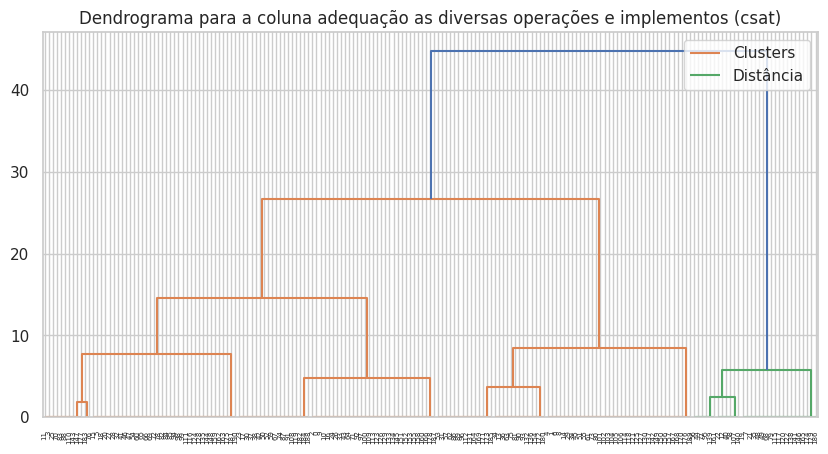

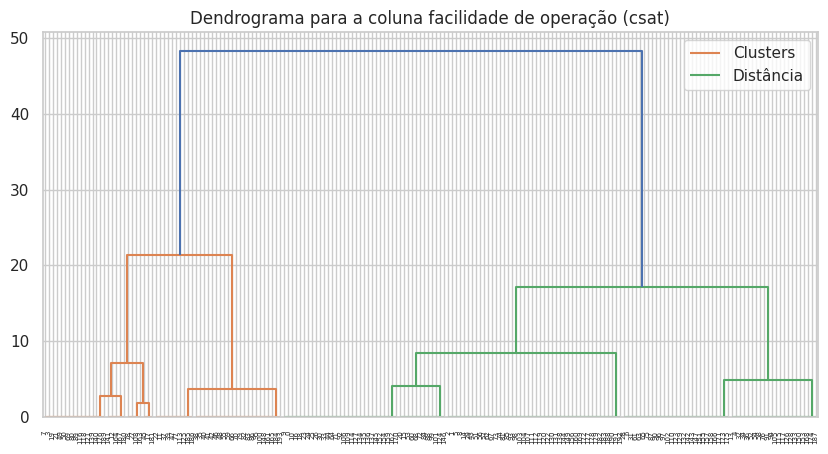

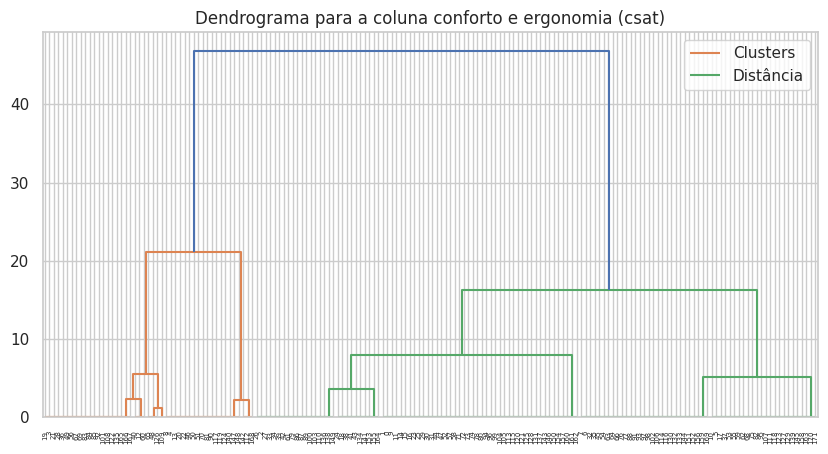

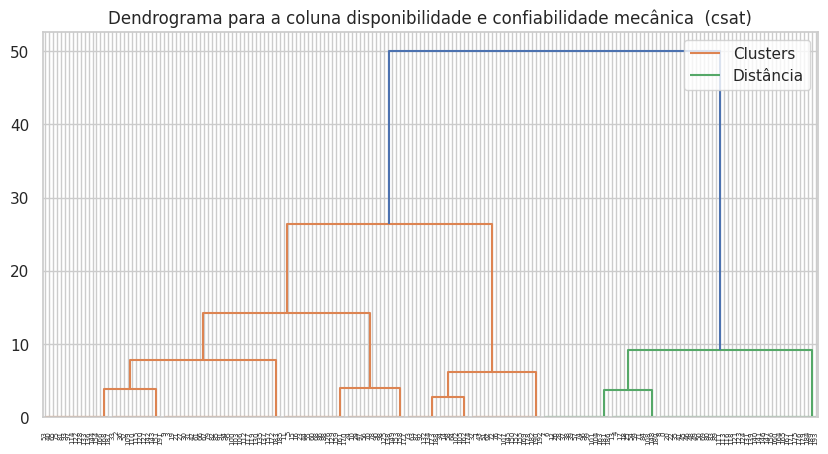

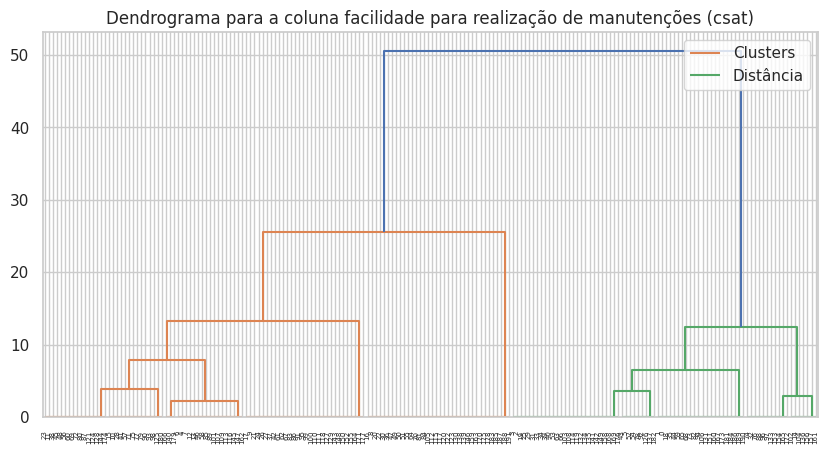

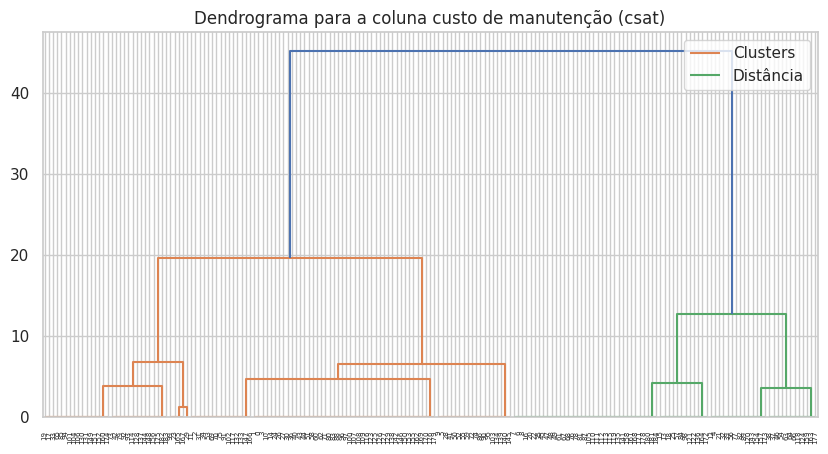

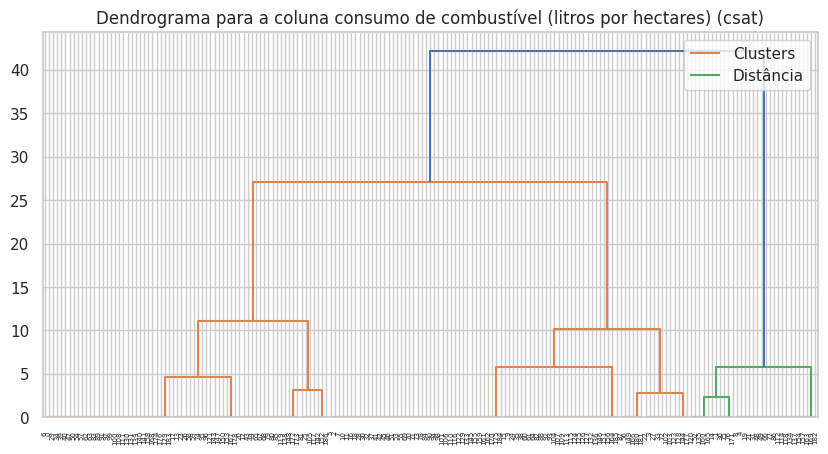

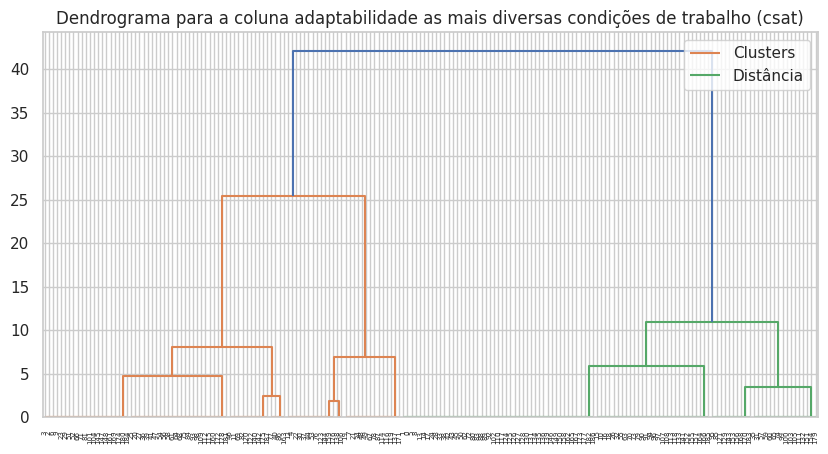

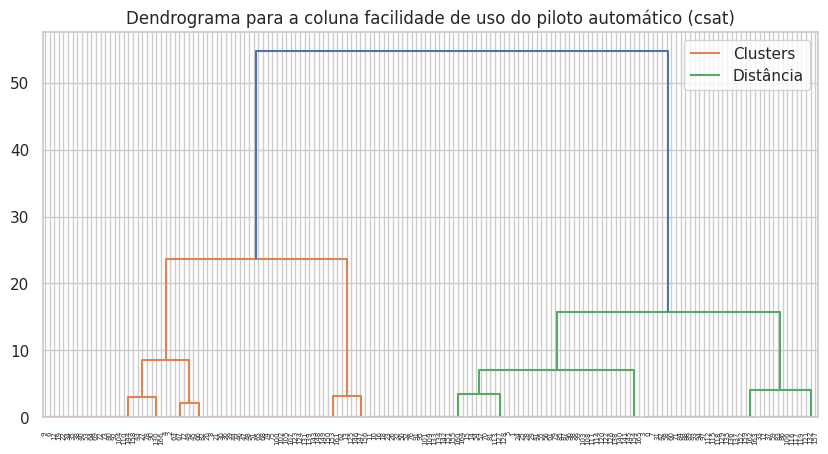

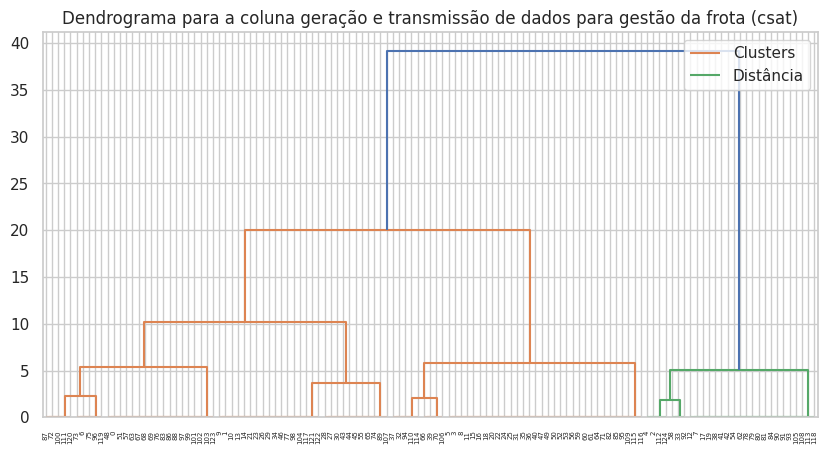

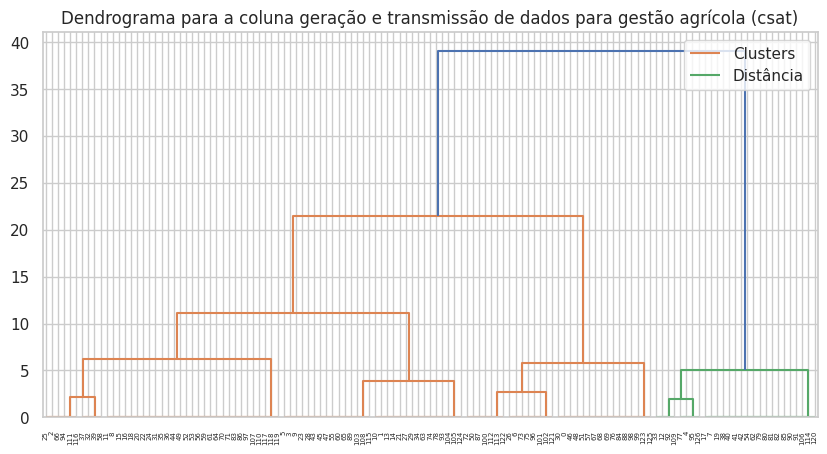

In [13]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Carregar a planilha
file_path = '/content/PlanilhaFiltradaDetratorCNH.xlsx'  # Substitua pelo caminho do arquivo
data = pd.read_excel(file_path)

# Identificar colunas numéricas
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Realizar agrupamento hierárquico em cada coluna numérica
for col in numeric_cols:
    # Remover valores nulos para o clustering
    column_data = data[col].dropna().values.reshape(-1, 1)

    # Aplicar o linkage para clustering hierárquico
    linked = linkage(column_data, method='ward')

    # Plotar o dendrograma para a coluna
    plt.figure(figsize=(10, 5))
    dendrogram(linked,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=False)

    # Adicionar título e rótulos
    plt.title(f'Dendrograma para a coluna {col}')

    # Adicionar uma legenda
    plt.legend(['Clusters', 'Distância'], loc='best')  # Personalize conforme necessário

    # Mostrar o gráfico
    plt.show()

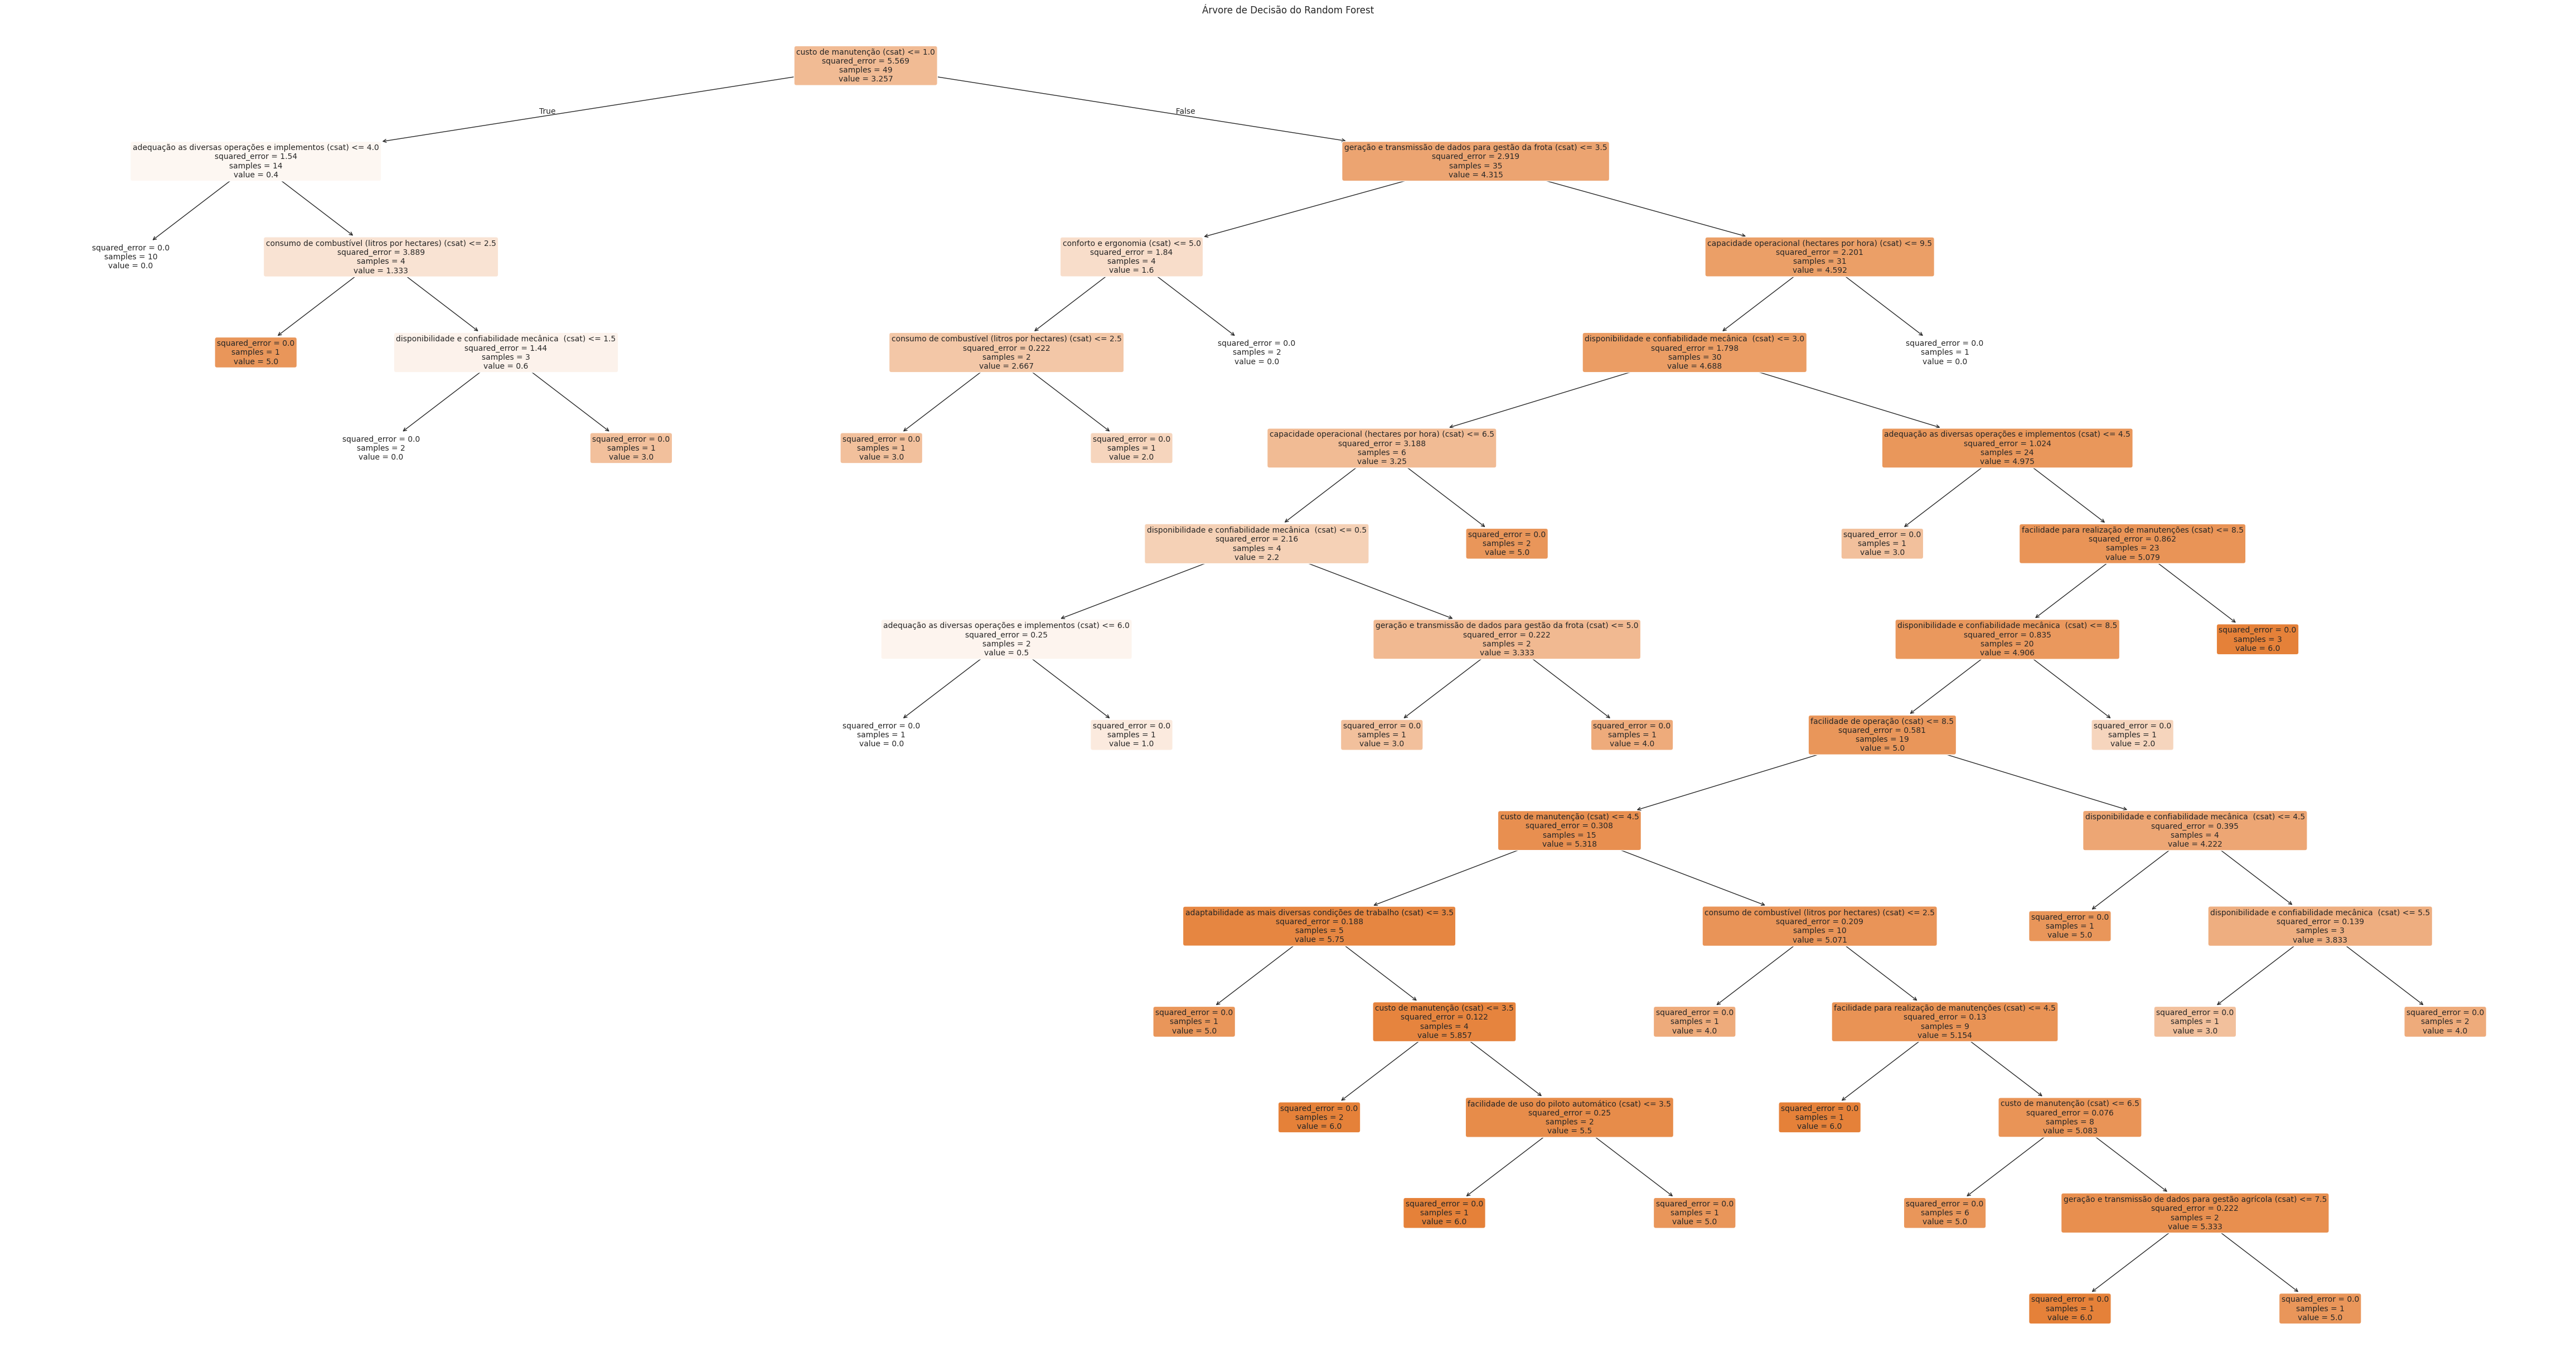

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

# Função para aplicar Random Forest e identificar as variáveis mais importantes
def importancia_variaveis_random_forest(arquivo_excel, nota_geral_col, sheet_name=0):
    # Carregar a planilha Excel
    df = pd.read_excel(arquivo_excel, sheet_name=sheet_name)

    # Filtrar apenas as colunas de perguntas CSAT
    csat_columns = [col for col in df.columns if '(csat)' in col]
    if not csat_columns:
        print("Nenhuma coluna CSAT foi encontrada na planilha.")
        return

    # Garantir que a coluna da nota geral está presente
    if nota_geral_col not in df.columns:
        print(f"A coluna '{nota_geral_col}' não foi encontrada na planilha.")
        return

    # Preparar os dados para o modelo
    csat_data = df[csat_columns + [nota_geral_col]].dropna()  # Remover linhas com valores ausentes
    X = csat_data[csat_columns]  # Variáveis independentes
    y = csat_data[nota_geral_col]  # Variável dependente (nota geral)

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Instanciar e treinar o modelo Random Forest
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # Calcular a importância das variáveis
    feature_importances = model.feature_importances_

    # Criar um DataFrame para exibir as importâncias
    importances_df = pd.DataFrame({
        'Feature': csat_columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Visualização de uma árvore de decisão do Random Forest
    # Selecionar a primeira árvore para visualização
    plt.figure(figsize=(20, 20))  # Aumentei a altura do gráfico
    plot_tree(model.estimators_[0], filled=True, feature_names=csat_columns, rounded=True, fontsize=10)

    # Ajuste nas margens para dar mais espaçamento
    plt.subplots_adjust(left=0, right=2.3, top=1.2, bottom=0)
    plt.title('Árvore de Decisão do Random Forest')
    plt.show()

    return importances_df

# Exemplo de uso
arquivo_excel = '/content/PlanilhaFiltradaDetratorCNH.xlsx'  # Substitua pelo caminho do arquivo
nota_geral_col = 'nota'  # Substitua pelo nome da coluna da nota geral
importancias = importancia_variaveis_random_forest(arquivo_excel, nota_geral_col)




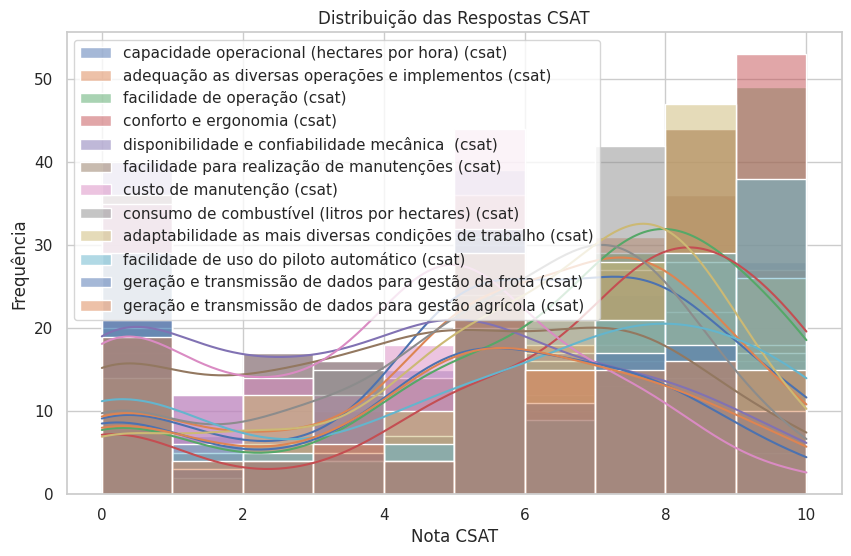

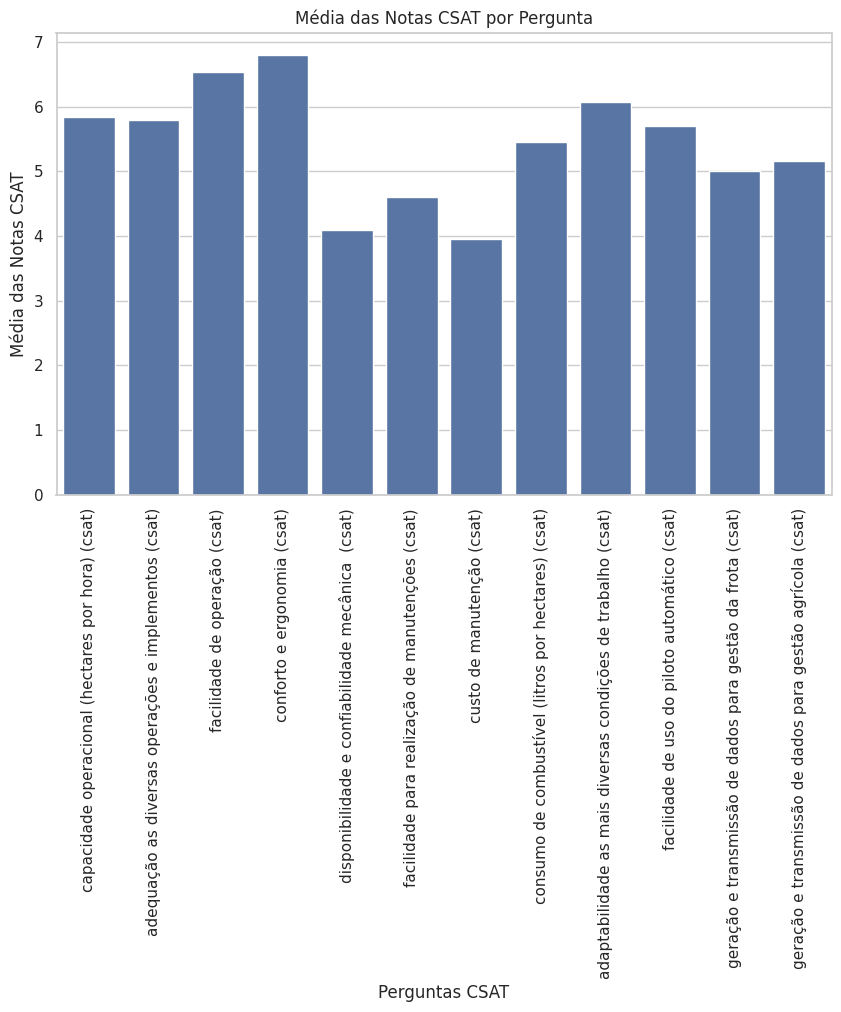

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Função para carregar dados e gerar gráficos sobre CSAT
def gerar_graficos_csat(arquivo_excel):
    # Carregar a planilha
    df = pd.read_excel(arquivo_excel, engine='openpyxl')

    # Identificar colunas CSAT (supondo que as colunas com 'CSAT' no nome sejam as desejadas)
    colunas_csat = [col for col in df.columns if 'csat' in col]

    if not colunas_csat:
        print("Nenhuma coluna CSAT encontrada no arquivo.")
        return

    # Histograma de todas as respostas CSAT
    plt.figure(figsize=(10, 6))
    for col in colunas_csat:
        sns.histplot(df[col], kde=True, label=col, bins=10, alpha=0.5)
    plt.title('Distribuição das Respostas CSAT')
    plt.xlabel('Nota CSAT')
    plt.ylabel('Frequência')
    plt.legend()
    plt.show()

    # Gráfico de Barras com a Média das Notas CSAT para cada pergunta
    medias_csat = df[colunas_csat].mean()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=medias_csat.index, y=medias_csat.values)
    plt.title('Média das Notas CSAT por Pergunta')
    plt.xlabel('Perguntas CSAT')
    plt.ylabel('Média das Notas CSAT')
    plt.xticks(rotation=90)
    plt.show()

# Caminho do arquivo Excel
arquivo_excel = '/content/PlanilhaFiltradaDetratorCNH.xlsx'

# Chamar a função para gerar gráficos sobre CSAT
gerar_graficos_csat(arquivo_excel)


